# Mr.HelpMateAI RAG System

## 1. Install and Import the Required Libraries

In [1]:
# Import all the required Libraries

import pdfplumber
from pathlib import Path
import pandas as pd
from operator import itemgetter
import os, json
import tiktoken
import openai
import chromadb
import warnings
warnings.filterwarnings("ignore")

## 2. Read, Process, and Chunk the PDF Files

We will be using [pdfplumber](https://https://pypi.org/project/pdfplumber/) to read and process the PDF files.

`pdfplumber` allows for better parsing of the PDF file as it can read various elements of the PDF apart from the plain text, such as, tables, images, etc. It also offers wide functionaties and visual debugging features to help with advanced preprocessing as well.

In [2]:
# Define the path of the PDF

pdf_path = 'Principal-Sample-Life-Insurance-Policy.pdf'

#### 2.1  Reading a single PDF file and exploring it through pdfplumber

In [3]:
# Open the PDF file
with pdfplumber.open(pdf_path) as pdf:

    # Get one of the pages from the PDF and examine it
    single_page = pdf.pages[6]

    # Extract text from the first page
    text = single_page.extract_text()

    # Extract tables from the first page
    tables = single_page.extract_tables()

    # Print the extracted text
    print(text)

Section A – Eligibility
Member Life Insurance Article 1
Member Accidental Death and Dismemberment Insurance Article 2
Dependent Life Insurance Article 3
Section B - Effective Dates
Member Life Insurance Article 1
Member Accidental Death and Dismemberment Insurance Article 2
Dependent Life Insurance Article 3
Section C - Individual Terminations
Member Life Insurance Article 1
Member Accidental Death and Dismemberment Insurance Article 2
Dependent Life Insurance Article 3
Termination for Fraud Article 4
Coverage While Outside of the United States Article 5
Section D - Continuation
Member Life Insurance Article 1
Dependent Insurance - Developmentally Disabled or
Physically Handicapped Children Article 2
Section E - Reinstatement
Reinstatement Article 1
Federal Required Family and Medical Leave Act (FMLA) Article 2
Reinstatement of Coverage for a Member or Dependent When
Coverage Ends due to Living Outside of the United States Article 3
Section F - Individual Purchase Rights
Member Life In

In [4]:
# Function to check whether a word is present in a table or not for segregation of regular text and tables

def check_bboxes(word, table_bbox):
    # Check whether word is inside a table bbox.
    l = word['x0'], word['top'], word['x1'], word['bottom']
    r = table_bbox
    return l[0] > r[0] and l[1] > r[1] and l[2] < r[2] and l[3] < r[3]

In [5]:
# Function to extract text from a PDF file.
# 1. Declare a variable p to store the iteration of the loop that will help us store page numbers alongside the text
# 2. Declare an empty list 'full_text' to store all the text files
# 3. Use pdfplumber to open the pdf pages one by one
# 4. Find the tables and their locations in the page
# 5. Extract the text from the tables in the variable 'tables'
# 6. Extract the regular words by calling the function check_bboxes() and checking whether words are present in the table or not
# 7. Use the cluster_objects utility to cluster non-table and table words together so that they retain the same chronology as in the original PDF
# 8. Declare an empty list 'lines' to store the page text
# 9. If a text element in present in the cluster, append it to 'lines', else if a table element is present, append the table
# 10. Append the page number and all lines to full_text, and increment 'p'
# 11. When the function has iterated over all pages, return the 'full_text' list

def extract_text_from_pdf(pdf_path):
    p = 0
    full_text = []


    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            page_no = f"Page {p+1}"
            text = page.extract_text()

            tables = page.find_tables()
            table_bboxes = [i.bbox for i in tables]
            tables = [{'table': i.extract(), 'top': i.bbox[1]} for i in tables]
            non_table_words = [word for word in page.extract_words() if not any(
                [check_bboxes(word, table_bbox) for table_bbox in table_bboxes])]
            lines = []

            for cluster in pdfplumber.utils.cluster_objects(non_table_words + tables, itemgetter('top'), tolerance=5):

                if 'text' in cluster[0]:
                    try:
                        lines.append(' '.join([i['text'] for i in cluster]))
                    except KeyError:
                        pass

                elif 'table' in cluster[0]:
                    lines.append(json.dumps(cluster[0]['table']))


            full_text.append([page_no, " ".join(lines)])
            p +=1

    return full_text

*Now that we have defined the function for extracting the text and tables from a PDF, let's iterate and call this function for all the PDFs in our drive and store them in a list.*

In [6]:

# Initialize an empty list to store the extracted texts and document names
data = []

# Process the PDF file
print(f"...Processing {pdf_path}")

# Call the function to extract the text from the PDF
extracted_text = extract_text_from_pdf(pdf_path)

# Convert the extracted list to the PDF, and add a column to store document names
extracted_text_df = pd.DataFrame(extracted_text, columns=['Page No.', 'Page_Text'])

# Append the extracted text and document name to the list
data.append(extracted_text_df)

# Print a message to indicate the PDF has been processed
print(f"PDF has been processed: {pdf_path}")

...Processing Principal-Sample-Life-Insurance-Policy.pdf
PDF has been processed: Principal-Sample-Life-Insurance-Policy.pdf


In [7]:
# Convert the data to a dataframe

insurance_pdf_data = pd.concat(data, ignore_index=True)

In [8]:
insurance_pdf_data

,Page No.,Page_Text
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...
1,Page 2,This page left blank intentionally
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...
3,Page 4,This page left blank intentionally
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...
...,...,...
59,Page 60,I f a Dependent who was insured dies during th...
60,Page 61,Section D - Claim Procedures Article 1 - Notic...
61,Page 62,A claimant may request an appeal of a claim de...
62,Page 63,This page left blank intentionally


In [9]:
# Check one of the extracted page texts to ensure that the text has been correctly read

insurance_pdf_data.Page_Text[2]

'POLICY RIDER GROUP INSURANCE POLICY NO: S655 COVERAGE: Life EMPLOYER: RHODE ISLAND JOHN DOE Effective on the later of the Date of Issue of this Group Policy or March 1, 2005, the following will apply to your Policy: From time to time The Principal may offer or provide certain employer groups who apply for coverage with The Principal a Financial Services Hotline and Grief Support Services or any other value added service for the employees of that employer group. In addition, The Principal may arrange for third party service providers (i.e., optometrists, health clubs), to provide discounted goods and services to those employer groups who apply for coverage with The Principal or who become insureds/enrollees of The Principal. While The Principal has arranged these goods, services and/or third party provider discounts, the third party service providers are liable to the applicants/insureds/enrollees for the provision of such goods and/or services. The Principal is not responsible for the

In [10]:
# Let's also check the length of all the texts as there might be some empty pages or pages with very few words that we can drop

insurance_pdf_data['Text_Length'] = insurance_pdf_data['Page_Text'].apply(lambda x: len(x.split(' ')))

In [11]:
insurance_pdf_data['Text_Length']

0      30
1       5
2     230
3       5
4     110
     ... 
59    285
60    418
61    322
62      5
63      8
Name: Text_Length, Length: 64, dtype: int64

In [12]:
# Retain only the rows with a text length of at least 10

insurance_pdf_data = insurance_pdf_data.loc[insurance_pdf_data['Text_Length'] >= 10]
insurance_pdf_data

,Page No.,Page_Text,Text_Length
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,30
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,230
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,110
5,Page 6,TABLE OF CONTENTS PART I - DEFINITIONS PART II...,153
6,Page 7,Section A – Eligibility Member Life Insurance ...,176
7,Page 8,Section A - Member Life Insurance Schedule of ...,171
8,Page 9,P ART I - DEFINITIONS When used in this Group ...,387
9,Page 10,T he legally recognized union of two eligible ...,251
10,Page 11,(2) has been placed with the Member or spouse ...,299
11,Page 12,An institution that is licensed as a Hospital ...,352


In [13]:
# Store the metadata for each page in a separate column

insurance_pdf_data['Metadata'] = insurance_pdf_data.apply(lambda x: {'Policy_Name': "Principal-Sample-Life-Insurance-Policy", 'Page_No.': x['Page No.']}, axis=1)

In [14]:
insurance_pdf_data

,Page No.,Page_Text,Text_Length,Metadata
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,30,{'Policy_Name': 'Principal-Sample-Life-Insuran...
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,230,{'Policy_Name': 'Principal-Sample-Life-Insuran...
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,110,{'Policy_Name': 'Principal-Sample-Life-Insuran...
5,Page 6,TABLE OF CONTENTS PART I - DEFINITIONS PART II...,153,{'Policy_Name': 'Principal-Sample-Life-Insuran...
6,Page 7,Section A – Eligibility Member Life Insurance ...,176,{'Policy_Name': 'Principal-Sample-Life-Insuran...
7,Page 8,Section A - Member Life Insurance Schedule of ...,171,{'Policy_Name': 'Principal-Sample-Life-Insuran...
8,Page 9,P ART I - DEFINITIONS When used in this Group ...,387,{'Policy_Name': 'Principal-Sample-Life-Insuran...
9,Page 10,T he legally recognized union of two eligible ...,251,{'Policy_Name': 'Principal-Sample-Life-Insuran...
10,Page 11,(2) has been placed with the Member or spouse ...,299,{'Policy_Name': 'Principal-Sample-Life-Insuran...
11,Page 12,An institution that is licensed as a Hospital ...,352,{'Policy_Name': 'Principal-Sample-Life-Insuran...


#### 2.2  Fixed-size PDF Chunking

In [15]:
# Iterating over all page titles to create the final df with individual chunks

page_nos = insurance_pdf_data["Page No."]

In [16]:
# Function to split text into fixed-size chunks
def split_text_into_chunks(text, chunk_size):
    chunks = []
    words = text.split()  # Split the text into words

    current_chunk = []  # Store words for the current chunk
    current_chunk_word_count = 0  # Count of words in the current chunk

    for word in words:
        if current_chunk_word_count + len(word) + 1 <= chunk_size:
            current_chunk.append(word)
            current_chunk_word_count += len(word) + 1
        else:
            chunks.append(' '.join(current_chunk))
            current_chunk = [word]
            current_chunk_word_count = len(word)

    if current_chunk:
        chunks.append(' '.join(current_chunk))

    return chunks

In [17]:
def process_page(page_no):
    page = insurance_pdf_data[insurance_pdf_data['Page No.'] == page_no].Page_Text.values[0]
    metadata = insurance_pdf_data[insurance_pdf_data['Page No.'] == page_no].Metadata.values[0]

    if page is not None:
        # setting chunk size as 500
        chunk_size = 500
        text_chunks = split_text_into_chunks(page, chunk_size)

        # Creating a DataFrame to store the chunks, page title and page metadata
        data = {'Title': [], 'Chunk Text': [], 'Metadata': []}

        for index, chunk in enumerate(text_chunks):
            data['Title'].append(page_no)
            data['Chunk Text'].append(chunk)
            # adding chunk no as part of metadata
            metadata['Chunk_No.'] = index
            data['Metadata'].append(metadata)

        return pd.DataFrame(data)

In [18]:
# creating a dataframe after calling process
all_dfs = []
for page_no in page_nos:
    df = process_page(page_no)
    if df is not None:
        all_dfs.append(df)

insurance_pdf_data = pd.concat(all_dfs, ignore_index=True)
insurance_pdf_data

,Title,Chunk Text,Metadata
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,{'Policy_Name': 'Principal-Sample-Life-Insuran...
1,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,{'Policy_Name': 'Principal-Sample-Life-Insuran...
2,Page 3,arrange for third party service providers (i.e...,{'Policy_Name': 'Principal-Sample-Life-Insuran...
3,Page 3,the provision of such goods and/or services no...,{'Policy_Name': 'Principal-Sample-Life-Insuran...
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,{'Policy_Name': 'Principal-Sample-Life-Insuran...
...,...,...,...
222,Page 61,incomplete claim. Written notification will be...,{'Policy_Name': 'Principal-Sample-Life-Insuran...
223,Page 62,A claimant may request an appeal of a claim de...,{'Policy_Name': 'Principal-Sample-Life-Insuran...
224,Page 62,"requested additional information, The Principa...",{'Policy_Name': 'Principal-Sample-Life-Insuran...
225,Page 62,may have the Member or Dependent whose loss is...,{'Policy_Name': 'Principal-Sample-Life-Insuran...


## 3. Generate and Store Embeddings using OpenAI and ChromaDB

In this section, we will embed the pages in the dataframe through OpenAI's `text-embedding-ada-002` model, and store them in a ChromaDB collection.

In [19]:
from sentence_transformers import SentenceTransformer, util

In [20]:
# Load the embedding model

model_name = "all-MiniLM-L6-v2"
embedder = SentenceTransformer(model_name)

In [21]:
# Function to generate embeddings for text

def generate_embeddings(texts):
    embeddings = embedder.encode(texts, convert_to_tensor=False)
    return embeddings

In [22]:
# Function to generate embedding on dataframe

def generate_embeddings_on_df(df):
  df['Embeddings'] = df['Chunk Text'].apply(lambda x: generate_embeddings([x])[0])

In [23]:
# Create embeddings for 'Chunk Text' column on all three dataframes

generate_embeddings_on_df(insurance_pdf_data)

In [24]:
# print the dataframe

insurance_pdf_data.head()

,Title,Chunk Text,Metadata,Embeddings
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,{'Policy_Name': 'Principal-Sample-Life-Insuran...,"[-0.025921866, 0.04777747, 0.055857733, 0.0423..."
1,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,{'Policy_Name': 'Principal-Sample-Life-Insuran...,"[-0.06453795, 0.04319712, -8.392538e-05, -0.00..."
2,Page 3,arrange for third party service providers (i.e...,{'Policy_Name': 'Principal-Sample-Life-Insuran...,"[-0.10200987, -0.028467739, -0.020565035, -0.0..."
3,Page 3,the provision of such goods and/or services no...,{'Policy_Name': 'Principal-Sample-Life-Insuran...,"[-0.09000835, 0.07658203, 0.004927679, -0.0830..."
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,{'Policy_Name': 'Principal-Sample-Life-Insuran...,"[-0.055241928, 0.06727764, 0.060153265, -0.032..."


In [25]:
import chromadb

In [26]:
# Call PersistentClient()

client = chromadb.PersistentClient()

Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given


In [27]:
# Initialise a collection in chroma and pass the embedding_function to it so that it used OpenAI embeddings to embed the documents

insurance_collection = client.get_or_create_collection(name='RAG_on_Insurance')

Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


In [28]:
insurance_collection.add(
    embeddings = insurance_pdf_data['Embeddings'].to_list(),
    documents = insurance_pdf_data['Chunk Text'].to_list(),
    metadatas = insurance_pdf_data['Metadata'].to_list(),
    ids = [str(i) for i in range(0, len(insurance_pdf_data['Embeddings']))]
)

Failed to send telemetry event CollectionAddEvent: capture() takes 1 positional argument but 3 were given


In [29]:
# Let's take a look at the first few entries in the collection

insurance_collection.get(
    ids = ['0','1','2'],
    include = ['embeddings', 'documents', 'metadatas']
)

Failed to send telemetry event CollectionGetEvent: capture() takes 1 positional argument but 3 were given


{'ids': ['0', '1', '2'],
 'embeddings': array([[-0.02592187,  0.04777747,  0.05585773, ..., -0.04932654,
         -0.05851152,  0.02355194],
        [-0.10579568, -0.00053027,  0.01657766, ..., -0.03772431,
          0.03662253, -0.04041132],
        [-0.06354082,  0.05870155,  0.07262769, ..., -0.07400384,
         -0.02375578, -0.00810615]]),
 'documents': ['DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/01/2014 711 HIGH STREET GEORGE RI 02903 GROUP POLICY FOR: RHODE ISLAND JOHN DOE ALL MEMBERS Group Member Life Insurance Print Date: 07/16/2014',
  'POLICY RIDER GROUP INSURANCE POLICY NO: S655 COVERAGE: Life EMPLOYER: RHODE ISLAND JOHN DOE Effective on the later of the Date of Issue of this Group Policy or March 1, 2005, the following will apply to your Policy: From time to time The Principal may offer or provide certain employer groups who apply for coverage with The Principal a Financial Services Hotline and Grief Support Services or any other value added service for the employees o

In [30]:
# create a cache collection

cache_collection = client.get_or_create_collection(name='Insurance_Cache')

Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


In [31]:
# peek few of elements from cache collection

cache_collection.peek()

Failed to send telemetry event CollectionGetEvent: capture() takes 1 positional argument but 3 were given


{'ids': ['What is the life insurance coverage for disability?',
  'What is the Proof of ADL Disability or Total Disability?',
  'What is condition of death while not wearing seat belt?',
  'What benefits are payable under Member Life Insurance and how are they affected by age or accelerated benefits?',
  'What are the premium rates and how are they calculated for different types of coverage?',
  'What are the conditions and limitations for Coverage During Disability and Accelerated Benefits?'],
 'embeddings': array([[-0.05065044,  0.11849421, -0.02794847, ..., -0.03774621,
          0.09379537,  0.06996422],
        [-0.09845495,  0.0599665 , -0.01844724, ...,  0.10967229,
          0.04604075,  0.03469605],
        [ 0.021985  ,  0.08126077, -0.03307081, ..., -0.03348075,
         -0.02619419,  0.01804475],
        [-0.02189873,  0.07203482, -0.00407243, ..., -0.08078302,
          0.04375521, -0.00504357],
        [ 0.01981961,  0.01237773,  0.00481234, ..., -0.05772035,
          0.

## 4. Semantic Search with Cache

In this section, we will perform a semantic search of a query in the collections embeddings to get several top semantically similar results.

In [32]:
# Read the user query

test_query = "What is the policy on eye issues?"

In [33]:
# Searh the Cache collection first
# Query the collection against the user query and return the top 20 results

cache_results = cache_collection.query(
    query_texts=test_query,
    n_results=1
)

Failed to send telemetry event CollectionQueryEvent: capture() takes 1 positional argument but 3 were given


In [34]:
cache_results

{'ids': [['What are the conditions and limitations for Coverage During Disability and Accelerated Benefits?']],
 'embeddings': None,
 'documents': [['What are the conditions and limitations for Coverage During Disability and Accelerated Benefits?']],
 'uris': None,
 'included': ['metadatas', 'documents', 'distances'],
 'data': None,
 'metadatas': [[{'documents5': "a. be actively engaged in business for profit within the meaning of the Internal Revenue Code, or be established as a legitimate nonprofit corporation within the meaning of the Internal Revenue Code; and b. make at least the level of premium contributions required for insurance on its eligible Members. The Policyholder must: (1) contribute at least 50% of the required premium for all Members (including disabled Members, if any); and c. if the Member is to contribute part of the premium, maintain the following participation percentages with respect to eligible employees and Dependents, excluding those for whom Proof of Good He

In [35]:
# Implementing Cache in Semantic Search

def search(query):

  # Set a threshold for cache search
  threshold = 0.2

  ids = []
  documents = []
  distances = []
  metadatas = []
  results_df = pd.DataFrame()

  # try to find from cache
  cache_results = cache_collection.query(
      query_texts=query,
      n_results=1
  )

  # If the distance is greater than the threshold, then return the results from the main collection.
  if cache_results['distances'][0] == [] or cache_results['distances'][0][0] > threshold:
        # Query the collection against the user query and return the top 10 results
        results = insurance_collection.query(
        query_texts=query,
        n_results=10
        )

        # Store the query in cache_collection as document w.r.t to ChromaDB so that it can be embedded and searched against later
        # Store retrieved text, ids, distances and metadatas in cache_collection as metadatas, so that they can be fetched easily if a query indeed matches to a query in cache
        Keys = []
        Values = []

        size = len(results.items())

        for key, val in results.items():
          if val is None:
            continue
          for i in range(size):
            Keys.append(str(key)+str(i))
            Values.append(str(val[0][i]))


        cache_collection.add(
            documents= [query],
            ids = [query],  # Or if you want to assign integers as IDs 0,1,2,.., then you can use "len(cache_results['documents'])" as will return the no. of queries currently in the cache and assign the next digit to the new query."
            metadatas = dict(zip(Keys, Values))
        )

        #print("Not found in cache. Found in main collection.")

        result_dict = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs":results["ids"][0]}
        results_df = pd.DataFrame.from_dict(result_dict)
        return results_df


  # If the distance is, however, less than the threshold, you can return the results from cache

  elif cache_results['distances'][0][0] <= threshold:
        cache_result_dict = cache_results['metadatas'][0][0]

        # Loop through each inner list and then through the dictionary
        for key, value in cache_result_dict.items():
            if 'ids' in key:
                ids.append(value)
            elif 'documents' in key:
                documents.append(value)
            elif 'distances' in key:
                distances.append(value)
            elif 'metadatas' in key:
                metadatas.append(value)

        #print("Found in cache!")

        # Create a DataFrame
        return pd.DataFrame({
          'IDs': ids,
          'Documents': documents,
          'Distances': distances,
          'Metadatas': metadatas
        })

## 5. Re-Ranking with a Cross Encoder

Re-ranking the results obtained from your semantic search can sometime significantly improve the relevance of the retrieved results. This is often done by passing the query paired with each of the retrieved responses into a cross-encoder to score the relevance of the response w.r.t. the query.

<br>

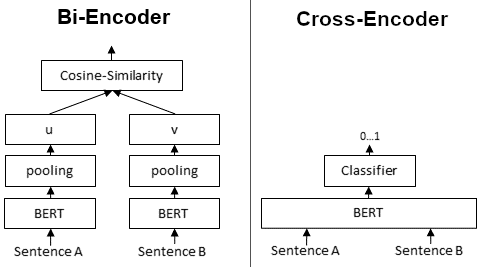

<br>

In [36]:
# Import the CrossEncoder library from sentence_transformers

from sentence_transformers import CrossEncoder, util

In [37]:
# Implementing Re-Ranking with Cross Encoder

def reranking(results_df):

    # Initialise the cross encoder model
    cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

    # Input (query, response) pairs for each of the top 20 responses received from the semantic search to the cross encoder
    # Generate the cross_encoder scores for these pairs
    cross_inputs = [[query, response] for response in results_df['Documents']]
    cross_rerank_scores = cross_encoder.predict(cross_inputs)

    # Store the rerank_scores in results_df
    results_df['Reranked_scores'] = cross_rerank_scores

    # Return the top 3 results from semantic search
    top_3_semantic = results_df.sort_values(by='Distances')

    # Return the top 3 results after reranking
    top_3_rerank = results_df.sort_values(by='Reranked_scores', ascending=False)
    top_3_RAG = top_3_rerank[["Documents", "Metadatas"]][:3]

    return top_3_RAG

## 6. Queries from Search Layer

In [38]:
query = "What is the life insurance coverage for disability?"
df = search(query)
top3_RAG = reranking(df)
top3_RAG

,Documents,Metadatas
5,Payment of benefits will be subject to the Ben...,"{'Page_No.': 'Page 7', 'Policy_Name': 'Princip..."
7,Section F - Individual Purchase Rights Article...,{'Policy_Name': 'Principal-Sample-Life-Insuran...
6,Section A - Member Life Insurance Schedule of ...,"{'Page_No.': 'Page 43', 'Policy_Name': 'Princi..."


In [39]:
query = "What is the Proof of ADL Disability or Total Disability?"
df = search(query)
top3_RAG = reranking(df)
top3_RAG

,Documents,Metadatas
0,The Principal may require that a ADL Disabled ...,"{'Page_No.': 'Page 8', 'Policy_Name': 'Princip..."
4,Payment of benefits will be subject to the Ben...,{'Policy_Name': 'Principal-Sample-Life-Insuran...
7,Coverage During Disability will cease on the e...,{'Policy_Name': 'Principal-Sample-Life-Insuran...


In [40]:
query = "What is condition of death while not wearing seat belt?"
df = search(query)
top3_RAG = reranking(df)
top3_RAG

,Documents,Metadatas
5,Exposure Exposure to the elements will be pres...,{'Policy_Name': 'Principal-Sample-Life-Insuran...
2,Section A - Member Life Insurance Schedule of ...,{'Policy_Name': 'Principal-Sample-Life-Insuran...
6,"a. willful self-injury or self-destruction, wh...",{'Policy_Name': 'Principal-Sample-Life-Insuran...


## 7. Retrieval Augmented Generation

Now that we have the final top search results, we can pass it to an GPT 3.5 along with the user query and a well-engineered prompt, to generate a direct answer to the query along with citations, rather than returning whole pages/chunks.

In [41]:
# Read the OpenAI API key
openai.api_key = open("OPENAI_API_Key.txt", "r").read().strip()
os.environ['OPENAI_API_KEY'] = openai.api_key

In [42]:
# Define the function to generate the response. Provide a comprehensive prompt that passes the user query and the top 3 results to the model

def generate_response(query, top_3_RAG):
    """
    Generate a response using GPT-3.5's ChatCompletion based on the user query and retrieved information.
    """
    messages = [
                {"role": "system", "content":  "You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents."},
                {"role": "user", "content": f"""You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents.
                                                You have a question asked by the user in '{query}' and you have some search results from a corpus of insurance documents in the dataframe '{top_3_RAG}'. These search results are essentially one page of an insurance document that may be relevant to the user query.

                                                The column 'documents' inside this dataframe contains the actual text from the policy document and the column 'metadata' contains the policy name and source page. The text inside the document may also contain tables in the format of a list of lists where each of the nested lists indicates a row.

                                                Use the documents in '{top_3_RAG}' to answer the query '{query}'. Frame an informative answer and also, use the dataframe to return the relevant policy names and page numbers as citations.

                                                Follow the guidelines below when performing the task.
                                                1. Try to provide relevant/accurate numbers if available.
                                                2. You don’t have to necessarily use all the information in the dataframe. Only choose information that is relevant.
                                                3. If the document text has tables with relevant information, please reformat the table and return the final information in a tabular in format.
                                                3. Use the Metadatas columns in the dataframe to retrieve and cite the policy name(s) and page numbers(s) as citation.
                                                4. If you can't provide the complete answer, please also provide any information that will help the user to search specific sections in the relevant cited documents.
                                                5. You are a customer facing assistant, so do not provide any information on internal workings, just answer the query directly.

                                                The generated response should answer the query directly addressing the user and avoiding additional information. If you think that the query is not relevant to the document, reply that the query is irrelevant. Provide the final response as a well-formatted and easily readable text along with the citation. Provide your complete response first with all information, and then provide the citations.
                                                """},
              ]

    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages
    )

    return response.choices[0].message.content.split('\n')

## 8. Queries from Generative Layer

In [43]:
def apply_cross_encoder(query, df):
  cross_inputs = [[query, response] for response in df['Documents']]
  # Initialise the cross encoder model
  cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')
  cross_rerank_scores = cross_encoder.predict(cross_inputs)
  df['Reranked_scores'] = cross_rerank_scores
  return df

In [44]:
def get_topn(n, df):
  top_3_rerank = df.sort_values(by='Reranked_scores', ascending=False)
  return top_3_rerank[["Documents", "Metadatas"]][:n]

In [45]:
query = 'What benefits are payable under Member Life Insurance and how are they affected by age or accelerated benefits?'
df = search(query)
df = apply_cross_encoder(query, df)
df = get_topn(3, df)
response = generate_response(query, df)
print("\n".join(response))

The benefits payable under Member Life Insurance include an Accelerated Benefit payment. This payment may be affected by certain conditions such as age restrictions. Specifically:

- Only one Accelerated Benefit payment will be made.
- The benefit payment may vary depending on the individual's age at the time of the claim.

To understand the specific details and restrictions related to age and accelerated benefits under the Member Life Insurance policy, please refer to the relevant policy document provided below:

- Policy Name: Principal-Sample-Life-Insurance
- Page Number: Page 53

For a more comprehensive understanding and precise information regarding the benefits payable under Member Life Insurance and how they are influenced by age or accelerated benefits, it's recommended to review the detailed policy document mentioned above. Further details can be found within the specified page number.

Below is the formatted table extracted from the policy document:

| Point                 

In [46]:
query = 'What are the premium rates and how are they calculated for different types of coverage?'
df = search(query)
df = apply_cross_encoder(query, df)
df = get_topn(3, df)
response = generate_response(query, df)
print("\n".join(response))

The premium rates for different types of coverage and how they are calculated may vary based on the specific insurance policy. Unfortunately, the provided documents do not contain direct information on premium rates and their calculation methods for different types of coverage.

However, to find relevant information on premium rates and calculations, you may refer to the "Section B - Premiums" in the policy document available on Page 21 of the Principals of Insurance document. This section could provide detailed insights into the premium rates and how they are determined for various coverage types.

In summary, for information on premium rates and their calculations for different coverage types, please refer to Section B - Premiums in the Principals of Insurance document available on Page 21.

Citations:
- Policy Name: Principals of Insurance
- Page Number: Page 21


In [47]:
query = 'What are the conditions and limitations for Coverage During Disability and Accelerated Benefits?'
df = search(query)
df = apply_cross_encoder(query, df)
df = get_topn(3, df)
response = generate_response(query, df)
print("\n".join(response))

Coverage During Disability and Accelerated Benefits are subject to certain conditions and limitations as outlined in the insurance policy document. Here are the key details based on the available information:

1. **Coverage During Disability**:
    - Coverage will cease on the earlier of the following:
        - The date the insured person is no longer totally disabled.
        - The maximum benefit period as specified in the policy.
    - Specific conditions related to total disability and benefit period will determine the continuation of coverage.

2. **Accelerated Benefits**:
    - Details regarding Accelerated Benefits coverage and limitations are not explicitly mentioned in the provided document snippet. It is advisable to refer to the complete policy document for comprehensive information on Accelerated Benefits.

Citations:
- **Policy Name**: Principal-Sample-Life-Insurance
- **Source Page**: As per the metadata provided in the document snippets.

For more detailed information o